# Credit scoring problem

Predict whether the customer will repay their credit within 90 days.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv('data/credit_scoring_sample.csv', sep=';')
df.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45063 entries, 0 to 45062
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      45063 non-null  int64  
 1   age                                   45063 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  45063 non-null  int64  
 3   DebtRatio                             45063 non-null  float64
 4   NumberOfTimes90DaysLate               45063 non-null  int64  
 5   NumberOfTime60-89DaysPastDueNotWorse  45063 non-null  int64  
 6   MonthlyIncome                         36420 non-null  float64
 7   NumberOfDependents                    43946 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 2.8 MB


All features are numerical type.

In [4]:
df.describe()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,45063.000000,3.642000e+04,43946.000000
mean,0.222489,51.210949,0.750993,352.062688,0.570712,0.505870,6.452263e+03,0.789628
std,0.415922,14.651533,6.184521,2467.556358,6.173106,6.153609,1.263817e+04,1.130813
min,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,40.000000,0.000000,0.176373,0.000000,0.000000,3.286000e+03,0.000000
50%,0.000000,51.000000,0.000000,0.373949,0.000000,0.000000,5.166000e+03,0.000000
75%,0.000000,62.000000,0.000000,0.857027,0.000000,0.000000,8.000000e+03,1.000000
max,1.000000,107.000000,98.000000,326442.000000,98.000000,98.000000,1.794060e+06,10.000000


In [5]:
df.isna().sum()

SeriousDlqin2yrs                           0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
NumberOfTimes90DaysLate                    0
NumberOfTime60-89DaysPastDueNotWorse       0
MonthlyIncome                           8643
NumberOfDependents                      1117
dtype: int64

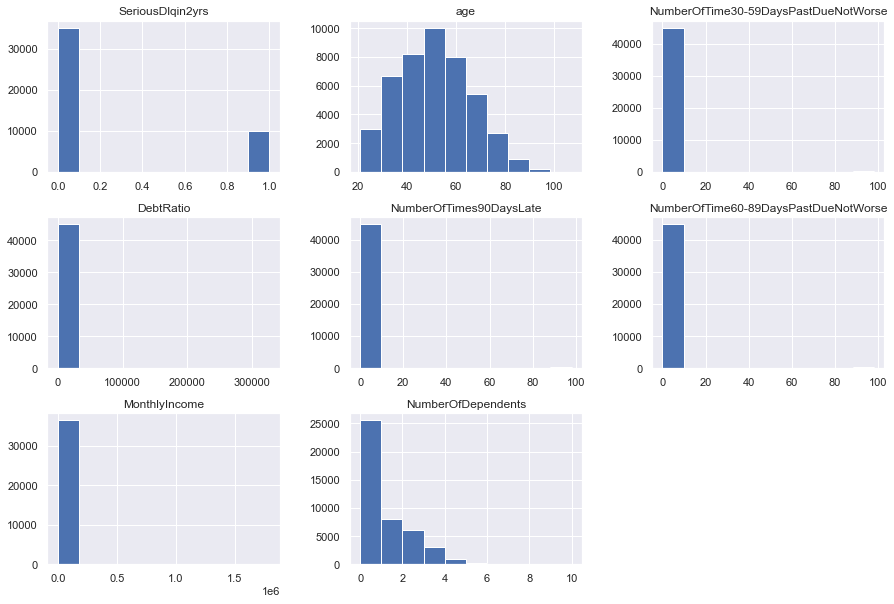

In [6]:
df.hist(figsize=(15, 10));

As we see in the first histogram, the target variable `SeriousDlqin2yrs` contains imbalanced classes (data values).

In [7]:
df['SeriousDlqin2yrs'].value_counts()

0    35037
1    10026
Name: SeriousDlqin2yrs, dtype: int64

For imbalanced class data (target values) it's recommended **NOT** to use accuracy as a evaluation metric, because it can be misleading.

In [8]:
X = df.drop(['SeriousDlqin2yrs'], axis=1)
y = df['SeriousDlqin2yrs']

X.shape, y.shape

((45063, 7), (45063,))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
29039,42,2,0.610770,5,0,3583.0,0.0
39939,43,0,0.275029,0,0,13583.0,1.0
5172,37,1,0.468790,0,1,7000.0,2.0
40842,22,0,0.000000,0,0,3600.0,0.0
2295,49,1,0.264999,0,0,5916.0,3.0


In [11]:
X_train.isna().sum()

age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
NumberOfTimes90DaysLate                    0
NumberOfTime60-89DaysPastDueNotWorse       0
MonthlyIncome                           6934
NumberOfDependents                       891
dtype: int64

### Fill missing values

In [12]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train = pd.DataFrame(data=X_train_imputed, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=X_test_imputed, columns=X_train.columns, index=X_test.index)

In [13]:
X_train.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
29039,42.0,2.0,0.610770,5.0,0.0,3583.0,0.0
39939,43.0,0.0,0.275029,0.0,0.0,13583.0,1.0
5172,37.0,1.0,0.468790,0.0,1.0,7000.0,2.0
40842,22.0,0.0,0.000000,0.0,0.0,3600.0,0.0
2295,49.0,1.0,0.264999,0.0,0.0,5916.0,3.0


In [14]:
X_train.isna().sum()

age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
MonthlyIncome                           0
NumberOfDependents                      0
dtype: int64

### Bootstrapping

**Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use np.random.seed(0) as before. What is the resulting interval estimate?**

In [15]:
np.random.seed(0)

def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

delayed_customers = X_train.loc[(y_train == 1).index, 'age'].values

age_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(delayed_customers, 1000)]

print("Age mean intervals:", stat_intervals(age_mean_scores, 0.1))

Age mean intervals: [51.04813592 51.30838696]


### Logistic Regression

**Perform a Grid Search with the scoring metric "roc_auc" for the parameter C. Which value of the parameter C is optimal?**

In [16]:
log_params = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
log_reg = LogisticRegression(class_weight='balanced', random_state=5)
grid_log = GridSearchCV(log_reg, log_params, scoring='roc_auc', cv=skf)

One of the important metrics of model quality is the Area Under the Curve (AUC). ROC AUC varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

In [17]:
%%time
grid_log.fit(X_train, y_train)

/home/lel/Escritorio/ml-projects/mlcourse/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lel/Escritorio/ml-projects/mlcourse/env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

CPU times: user 21.2 s, sys: 895 ms, total: 22.1 s
Wall time: 6.08 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [18]:
grid_log.best_params_

{'C': 0.01}

**Can we consider the best model stable? The model is stable if the standard deviation on validation is less than 0.5%. Save the ROC AUC value of the best model; it will be useful for the following tasks.**

In [19]:
grid_log.cv_results_

{'mean_fit_time': array([0.27886186, 0.25231485, 0.11872153, 0.14375844, 0.17104263,
        0.17899895]),
 'std_fit_time': array([0.10134718, 0.13611739, 0.01162121, 0.02484808, 0.04770385,
        0.05812356]),
 'mean_score_time': array([0.00807228, 0.00536084, 0.00470738, 0.00477242, 0.00476384,
        0.00470386]),
 'std_score_time': array([2.19418535e-03, 1.09595869e-03, 3.67459884e-05, 3.87985492e-05,
        2.10538590e-05, 2.25592864e-05]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10}],
 'split0_test_score': array([0.78286732, 0.78706751, 0.80810725, 0.79094478, 0.7864011 ,
        0.78640311]),
 'split1_test_score': array([0.78731834, 0.81206427, 0.81239798, 0.79919248, 0.79923205,
        0.79193216]),
 'split2_test_score': array([0.8116706 , 0.813

In [20]:
valid_std = np.array([0.01317717, 0.0113301 , 0.00315364, 0.0095399 , 0.01299355, 0.01259033]).std()
print("Std on alidation (in %)", valid_std * 100)

Std on alidation (in %) 0.3495870115592349


0.349 is less than 0.5%, so the model is stable.

**Feature importance is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?**

In [31]:
# Make a copy of coefficients, or use the parameter copy from pd.DataFrame
coefs = grid_log.best_estimator_.coef_.ravel().copy()

fi_log = pd.DataFrame(data=coefs, columns=['importance'],
                      index=X_train.columns)
fi_log['importance'] = np.abs(fi_log['importance'])
fi_log.sort_values(by='importance', ascending=False, inplace=True)
fi_log

,importance
NumberOfTime30-59DaysPastDueNotWorse,0.503507
NumberOfTimes90DaysLate,0.455459
NumberOfTime60-89DaysPastDueNotWorse,0.388990
NumberOfDependents,0.077781
age,0.012215
DebtRatio,0.000010
MonthlyIncome,0.000006


In [28]:
grid_log.best_estimator_.coef_

array([[-1.22149740e-02,  5.03507111e-01, -9.87962661e-06,
         4.55459242e-01,  3.88989537e-01, -5.73016875e-06,
         7.77810681e-02]])

**Calculate how much DebtRatio affects our prediction using the softmax function. What is its value?**

In [39]:
#To use softmax function, we need to set multi_class in the logistic regression's constructor
log_reg_multi = LogisticRegression(multi_class='multinomial', class_weight='balanced', random_state=5,
                                   **grid_log.best_params_)
log_reg_multi.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', multi_class='multinomial',
                   random_state=5)

In [42]:
log_reg_multi.coef_

array([[-6.14262200e-03,  2.54072973e-01, -4.94898002e-06,
         2.29834750e-01,  1.96316419e-01, -2.89790122e-06,
         3.92248479e-02]])

In [46]:
def show_feature_importances(coefs, columns, abs_=False, normalize=False, ascending_=False):
    #flatten() returns a copy, so there's no need for set the parameter copy=True 
    df = pd.DataFrame(data=coefs.flatten(), columns=['importance'], index=columns) 
    if(abs_):
        df['importance'] = np.abs(df['importance'])
    if(normalize):
        df['importance'] = (df['importance']-min(df['importance']))/(max(df['importance'])-min(df['importance']))
    
    df.sort_values(by='importance', ascending=ascending_)
    return df

In [52]:
fi_log_multi = show_feature_importances(log_reg_multi.coef_, X_train.columns, normalize=True)
fi_log_multi

,importance
age,0.000000
NumberOfTime30-59DaysPastDueNotWorse,1.000000
DebtRatio,0.023587
NumberOfTimes90DaysLate,0.906853
NumberOfTime60-89DaysPastDueNotWorse,0.778043
MonthlyIncome,0.023595
NumberOfDependents,0.174346


In [45]:
log_reg_multi.coef_

array([[-6.14262200e-03,  2.54072973e-01, -4.94898002e-06,
         2.29834750e-01,  1.96316419e-01, -2.89790122e-06,
         3.92248479e-02]])

`flatten()` also works!

### Random forest

**How much higher is the ROC AUC of the best random forest model than that of the best logistic regression on validation?**

In [54]:
forest_params = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42)
grid_forest = GridSearchCV(forest, forest_params, scoring='roc_auc', cv=skf)

In [55]:
%%time
grid_forest.fit(X_train, y_train)

CPU times: user 48.5 s, sys: 4.74 s, total: 53.2 s
Wall time: 2min 10s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=42),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [56]:
grid_log.best_score_, grid_forest.best_score_

(0.8133785002330232, 0.8358752763999855)

In [60]:
(grid_forest.best_score_ - grid_log.best_score_) * 100

2.249677616696233

**What feature has the weakest impact in the Random Forest model?**

In [63]:
show_feature_importances(grid_forest.best_estimator_.feature_importances_, X_train.columns)

,importance
age,0.117583
NumberOfTime30-59DaysPastDueNotWorse,0.295302
DebtRatio,0.081423
NumberOfTimes90DaysLate,0.281716
NumberOfTime60-89DaysPastDueNotWorse,0.149937
MonthlyIncome,0.059761
NumberOfDependents,0.014278


### Bagging

**What the best ROC AUC you've got for bagging with logistic regression as a base estimator?**

In [67]:
bag_params = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

bag_clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, random_state=42)
random_bag = RandomizedSearchCV(bag_clf, bag_params, n_iter=20, scoring='roc_auc', n_jobs=-1, 
                                cv=skf, random_state=1)

In [68]:
%%time
random_bag.fit(X_train, y_train)

CPU times: user 30.1 s, sys: 1.44 s, total: 31.5 s
Wall time: 6min 2s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(base_estimator=LogisticRegression(),
                                               n_estimators=100,
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   random_state=1, scoring='roc_auc')

In [70]:
random_bag.best_score_

0.7771115246356165

In [69]:
random_bag.best_params_

{'max_samples': 0.7, 'max_features': 2, 'base_estimator__C': 100}